In [ ]:
# Mount Google Drive and change directory
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive'
    print(f"Mounting and switching to: {path_to_file}")
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
Mounting and switching to: /content/gdrive/My Drive
/content/gdrive/My Drive


In [ ]:
# Set paths
# Path to your dataset inside Google Drive
data_root = "/content/gdrive/My Drive/split_dataset"

train_dir = f"{data_root}/train"
val_dir = f"{data_root}/val"
test_dir = f"{data_root}/test"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [ ]:
# Datasets and Dataloaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

## ViT

In [ ]:
import torch
import torch.nn as nn
from transformers import ViTModel

# Classification version of ViTImageRegressor
class ViTImageClassifier(nn.Module):
    def __init__(self, vit_model_name="google/vit-base-patch16-224-in21k", num_classes=5, dropout=0.3):
        super(ViTImageClassifier, self).__init__()
        self.vit = ViTModel.from_pretrained(vit_model_name, output_attentions=True)
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.vit.config.hidden_size, num_classes)
        )
        self.attentions = None  # Will store last attention maps

    def forward(self, image):
        output = self.vit(pixel_values=image)
        self.attentions = output.attentions  # List of attention tensors
        x = output.last_hidden_state[:, 0]  # CLS token
        return self.head(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTImageClassifier(num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
def train_model(model, train_loader, val_loader, epochs=10):
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)
        val_acc = evaluate(model, val_loader)
        print(f"📦 Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "vit_classifier_best.pth")
            print("✅ Saved best model")

def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            correct += (outputs.argmax(1) == labels).sum().item()
    return correct / len(loader.dataset)


## With Data Preprocessing

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import ViTFeatureExtractor
from torchvision import datasets, transforms
from tqdm import tqdm

# ViT normalization values
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

vit_train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),   # like zoom
    transforms.RandomRotation(15),                         # rotation_range
    transforms.RandomHorizontalFlip(),                     # horizontal_flip
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # width/height shift
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # roughly matches rescale + in21k norm
])

# Set paths
# Path to your dataset inside Google Drive
data_root = "/content/gdrive/My Drive/split_dataset"

train_dir = f"{data_root}/train"
val_dir = f"{data_root}/val"
test_dir = f"{data_root}/test"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your ImageFolder datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=vit_train_transform)
val_dataset   = datasets.ImageFolder(root=val_dir, transform=vit_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

class_names = train_dataset.classes

In [ ]:
train_model(model, train_loader, val_loader, epochs=10)

Epoch 1/10: 100%|██████████| 81/81 [00:19<00:00,  4.08it/s]


📦 Epoch 1: Train Acc = 0.7124, Val Acc = 0.7523
✅ Saved best model


Epoch 2/10: 100%|██████████| 81/81 [00:25<00:00,  3.16it/s]


📦 Epoch 2: Train Acc = 0.7659, Val Acc = 0.7341


Epoch 3/10: 100%|██████████| 81/81 [00:19<00:00,  4.09it/s]


📦 Epoch 3: Train Acc = 0.7729, Val Acc = 0.7923
✅ Saved best model


Epoch 4/10: 100%|██████████| 81/81 [00:25<00:00,  3.18it/s]


📦 Epoch 4: Train Acc = 0.8045, Val Acc = 0.8033
✅ Saved best model


Epoch 5/10: 100%|██████████| 81/81 [00:25<00:00,  3.21it/s]


📦 Epoch 5: Train Acc = 0.8155, Val Acc = 0.8306
✅ Saved best model


Epoch 6/10: 100%|██████████| 81/81 [00:25<00:00,  3.20it/s]


📦 Epoch 6: Train Acc = 0.8147, Val Acc = 0.8197


Epoch 7/10: 100%|██████████| 81/81 [00:20<00:00,  3.90it/s]


📦 Epoch 7: Train Acc = 0.8314, Val Acc = 0.8179


Epoch 8/10: 100%|██████████| 81/81 [00:19<00:00,  4.09it/s]


📦 Epoch 8: Train Acc = 0.8549, Val Acc = 0.7923


Epoch 9/10: 100%|██████████| 81/81 [00:19<00:00,  4.09it/s]


📦 Epoch 9: Train Acc = 0.8205, Val Acc = 0.7832


Epoch 10/10: 100%|██████████| 81/81 [00:19<00:00,  4.08it/s]


📦 Epoch 10: Train Acc = 0.8502, Val Acc = 0.8197


In [ ]:
# Use the same transform as training/validation
test_dataset = datasets.ImageFolder(root=test_dir, transform=vit_transform)

# Define test DataLoader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

class_names = test_dataset.classes

def evaluate_test(model, loader):
    model.eval()
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = correct / len(loader.dataset)
    print(f"✅ Test Accuracy: {acc:.4f}")
    return all_labels, all_preds

In [ ]:
# Evaluate on test set
true_labels, predictions = evaluate_test(model, test_loader)

✅ Test Accuracy: 0.8200


📊 Test Set Evaluation Metrics:
Accuracy       : 0.8200
Precision (avg): 0.7258
Recall (avg)   : 0.5953
F1 Score (avg) : 0.6109
Cohen's Kappa  : 0.7207

📋 Classification Report:

                precision    recall  f1-score   support

          Mild       0.62      0.62      0.62        56
      Moderate       0.68      0.88      0.77       150
         No_DR       0.96      0.97      0.97       271
Proliferate_DR       0.86      0.43      0.58        44
        Severe       0.50      0.07      0.12        29

      accuracy                           0.82       550
     macro avg       0.73      0.60      0.61       550
  weighted avg       0.82      0.82      0.80       550



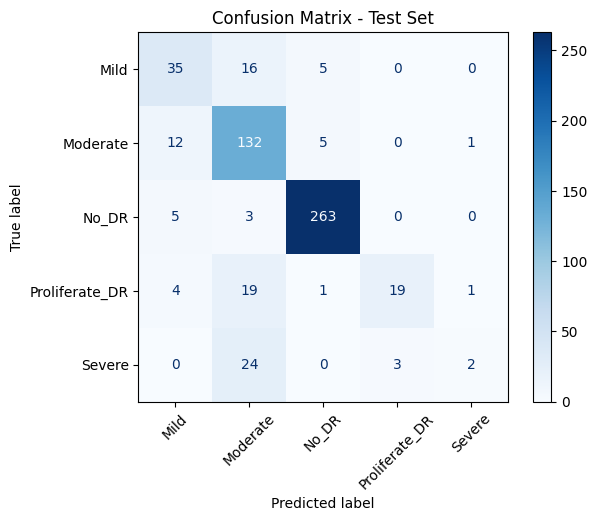

In [ ]:
# Evaluate on test set
true_labels, predictions = evaluate_test(model, test_loader)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Compute metrics
acc   = accuracy_score(true_labels, predictions)
prec  = precision_score(true_labels, predictions, average='macro')
rec   = recall_score(true_labels, predictions, average='macro')
f1    = f1_score(true_labels, predictions, average='macro')
kappa = cohen_kappa_score(true_labels, predictions)

# Print metrics
print("📊 Test Set Evaluation Metrics:")
print(f"Accuracy       : {acc:.4f}")
print(f"Precision (avg): {prec:.4f}")
print(f"Recall (avg)   : {rec:.4f}")
print(f"F1 Score (avg) : {f1:.4f}")
print(f"Cohen's Kappa  : {kappa:.4f}")

# Detailed classification report
print("\n📋 Classification Report:\n")
print(classification_report(true_labels, predictions, target_names=class_names))

# Confusion matrix plot
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.show()


## For LLM Integration

In [ ]:
def get_prediction_and_attention_for_llm(model, image_path, transform, class_names):
    model.eval()
    pil_img = Image.open(image_path).convert("RGB")
    input_tensor = transform(pil_img).unsqueeze(0).to(device)

    # Run prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs).item()
        confidence = probs[0, pred_idx].item()

    predicted_label = class_names[pred_idx]

    # Extract CLS attention
    attn = model.attentions[-1][0]  # [heads, tokens, tokens]
    attn_mean = attn.mean(dim=0)   # [tokens, tokens]
    cls_attn = attn_mean[0, 1:]    # CLS → patch tokens
    attn_map = cls_attn.reshape(14, 14).cpu().numpy()

    # Resize and normalize attention
    attn_resized = cv2.resize(attn_map, (224, 224))
    attn_resized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min() + 1e-8)
    attn_uint8 = np.uint8(attn_resized * 255)

    # Generate attention overlay image
    img_np = np.array(pil_img.resize((224, 224)))
    heatmap = cv2.applyColorMap(attn_uint8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    return {
        "predicted_label": predicted_label,
        "confidence": confidence,
        "attention_map": attn_resized,  # normalized attention
        "attention_overlay": overlay,   # BGR image (NumPy array)
        "raw_image": img_np             # original resized image
    }


Prediction: Moderate
Confidence: 0.70


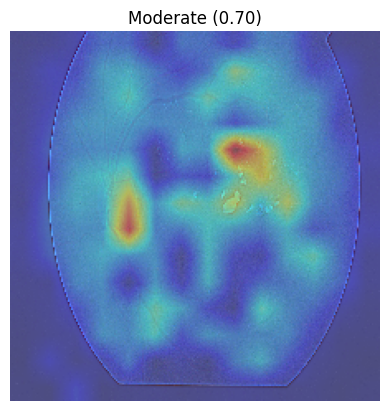

In [ ]:
# Pick a test image
image_path, _ = test_dataset.samples[123]

result = get_prediction_and_attention_for_llm(
    model=model,
    image_path=image_path,
    transform=vit_transform,
    class_names=test_dataset.classes
)

# Print result
print("Prediction:", result["predicted_label"])
print("Confidence:", f"{result['confidence']:.2f}")

# Show the overlay (optional)
plt.imshow(cv2.cvtColor(result["attention_overlay"], cv2.COLOR_BGR2RGB))
plt.title(f"{result['predicted_label']} ({result['confidence']:.2f})")
plt.axis("off")
plt.show()


In [ ]:
def get_prediction_and_attention_for_llm(model, image_path, transform, class_names):
    model.eval()
    pil_img = Image.open(image_path).convert("RGB")
    input_tensor = transform(pil_img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs).item()
        confidence = probs[0, pred_idx].item()

    predicted_label = class_names[pred_idx]

    # Extract attention map
    attn = model.attentions[-1][0]
    attn_mean = attn.mean(dim=0)
    cls_attn = attn_mean[0, 1:]
    attn_map = cls_attn.reshape(14, 14).cpu().numpy()
    attn_map = cv2.resize(attn_map, (224, 224))
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
    attn_uint8 = np.uint8(attn_map * 255)

    img_np = np.array(pil_img.resize((224, 224)))
    heatmap = cv2.applyColorMap(attn_uint8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # Convert BGR → RGB and then to PIL.Image (for in-memory base64)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    overlay_pil = Image.fromarray(overlay_rgb)

    return {
        "predicted_label": predicted_label,
        "confidence": confidence * 100,
        "overlay_image": overlay_pil
    }


In [ ]:
!pip install --upgrade langchain langchain-community langchain-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.2/437.2 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.55
    Uninstalling langchain-core-0.3.55:
      Successfully uninstalled langchain-core-0.3.55


In [ ]:
import base64
from PIL import Image
from io import BytesIO
from langchain_core.runnables import RunnableLambda
from langchain.schema import HumanMessage
from langchain.chat_models import ChatOpenAI
import json

# Helper: convert image to base64 for GPT-4V
def encode_image_base64_from_pil(pil_image):
    buffered = BytesIO()
    pil_image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

import os
from langchain.chat_models import ChatOpenAI

# Set API key (not recommended for production code)
os.environ["OPENAI_API_KEY"] = "" #ADD YOUR KEY HERE (removed to avoid leaking our key)

# Now initialize the model
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Create pipeline using RunnableLambda
def generate_explanation_from_pil(pil_image, prediction_label, confidence):
    image_b64 = encode_image_base64_from_pil(pil_image)

    prompt = (
        "This shows the image of a retina and an attention heatmap from our model overlaid on each other. "
        f"The model predicted '{prediction_label}', please state the prediction when providing the explanation. "
        f"The confidence is {confidence:.1f}%. You are a doctor's assistant. "
        "Please explain why the model made this prediction in natural language, and tell the doctor what parts of the retina are most important for this result. "
        "Try to name specific parts within the image that are of interest, particularly in reference to parts of the retina. In particular, describe to the doctor where they should focus on for follow up study or investigation"
        "Ensure that areas of interest are listed in order of importance. The parts of the image that are the most red should be the main focus first, as this is the area that received greatest attention."
    )

    message = HumanMessage(
        content=[
            {"type": "text", "text": prompt},
            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_b64}"}}
        ]
    )

    response = llm.invoke([message])
    return response.content

In [ ]:
image_path = test_dataset.samples[94][0]

result = get_prediction_and_attention_for_llm(
    model=model,
    image_path=image_path,
    transform=vit_transform,
    class_names=test_dataset.classes
)

explanation = generate_explanation_from_pil(
    pil_image=result["overlay_image"],
    prediction_label=result["predicted_label"],
    confidence=result["confidence"]
)

print("🧠 LLM Explanation:\n", explanation)


🧠 LLM Explanation:
 The model predicted 'Moderate' with a confidence of 83.7%. The Grad-CAM heatmap highlights areas of the retina that were most influential in making this prediction. Here's a breakdown of the key areas to focus on:

1. **Central Retina**: The most intense red areas are located centrally. This suggests significant features or abnormalities that contributed heavily to the prediction. The central retina, including the macula, should be closely examined for signs of diabetic retinopathy or other conditions.

2. **Upper Peripheral Region**: There is a notable red area in the upper part of the retina. This indicates that changes or features in this region were also important for the model's decision. Investigate for any microaneurysms or hemorrhages.

3. **Lower Peripheral Region**: Another area of interest is the lower peripheral region, which shows red and orange hues. This suggests potential abnormalities that need further examination.

4. **Right Peripheral Region**: T

In [ ]:
import matplotlib.pyplot as plt

def display_image_with_llm_text(pil_image, explanation_text, title="Grad-CAM + LLM Explanation"):
    plt.figure(figsize=(10, 6))

    # Image
    plt.subplot(1, 2, 1)
    plt.imshow(pil_image)
    plt.title("Grad-CAM Overlay")
    plt.axis("off")

    # Text
    plt.subplot(1, 2, 2)
    plt.text(0, 1, explanation_text, wrap=True, fontsize=10, verticalalignment='top')
    plt.axis("off")
    plt.title("LLM Explanation", fontsize=12)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


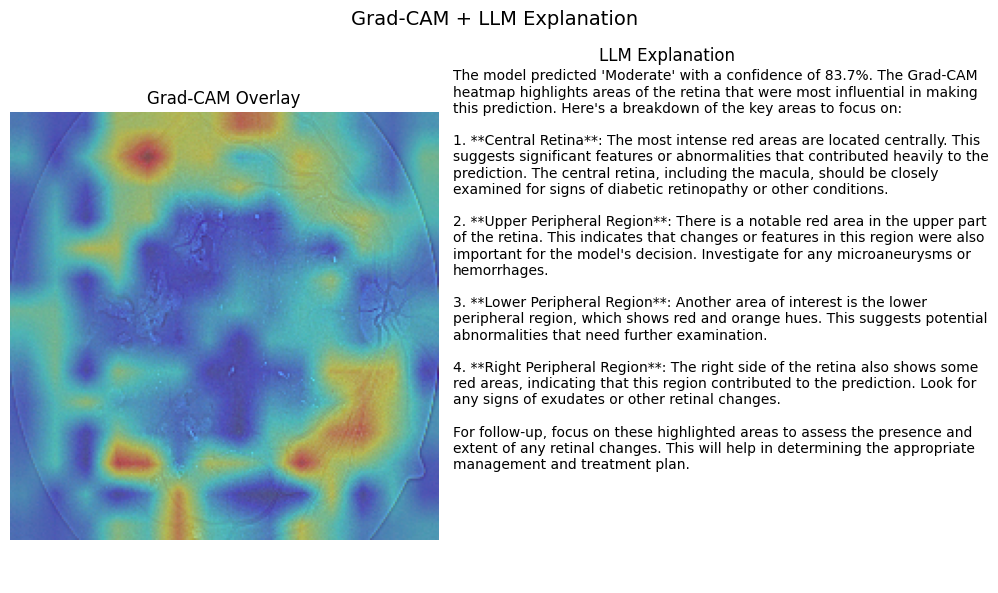

In [ ]:
display_image_with_llm_text(result["overlay_image"], explanation)

In [ ]:
torch.save(model.state_dict(), "vit_classifier.pth")
print("✅ Model weights saved to vit_classifier.pth")

✅ Model weights saved to vit_classifier.pth


## Binary Classification Instead

📊 Binary Classification Metrics (No DR vs Has DR):
Accuracy       : 0.9655
Precision      : 0.9710
Recall         : 0.9606
F1 Score       : 0.9658
ROC AUC        : 0.9897

🔍 Confusion Matrix:


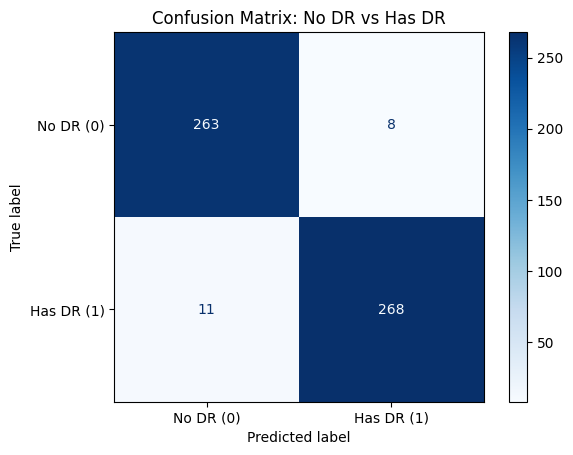

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Run predictions and collect true labels
model.eval()
true_labels = []
predicted_labels = []
predicted_probs = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        # Convert to CPU
        labels_np = labels.cpu().numpy()
        preds_np = preds.cpu().numpy()
        probs_np = probs.cpu().numpy()

        true_labels.extend(labels_np)
        predicted_labels.extend(preds_np)
        predicted_probs.extend(probs_np)

# Step 2: Convert multiclass to binary
def convert_to_binary(y):
    return np.array([0 if label == 2 else 1 for label in y])

y_true_bin = convert_to_binary(true_labels)
y_pred_bin = convert_to_binary(predicted_labels)
y_prob_bin = [1 - prob[2] for prob in predicted_probs]  # Probability of class ≠ 2

# Step 3: Compute metrics
acc   = accuracy_score(y_true_bin, y_pred_bin)
prec  = precision_score(y_true_bin, y_pred_bin)
rec   = recall_score(y_true_bin, y_pred_bin)
f1    = f1_score(y_true_bin, y_pred_bin)
auc   = roc_auc_score(y_true_bin, y_prob_bin)

# Step 4: Confusion matrix
cm = confusion_matrix(y_true_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No DR (0)", "Has DR (1)"])

# Step 5: Print results
print("📊 Binary Classification Metrics (No DR vs Has DR):")
print(f"Accuracy       : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"ROC AUC        : {auc:.4f}")
print("\n🔍 Confusion Matrix:")
disp.plot(cmap="Blues", xticks_rotation=0)
plt.title("Confusion Matrix: No DR vs Has DR")
plt.show()
